> Everything was started here


<img src="./prop_env.png" width="480" height="240"/>

A big ugly dense indoor factory hall



# A short note on limitations 
* I could not fit a DL (LSTM-CNN) structure to the data, why? because the data was imbalanced. what does it means? Suppose that you have 96 dogs and only 4 cats. If you classify any creature as a dog, your expected success is nearly 96% 

    1. There are at least three branches of studies to solve this problem

        1. Data augmentation --> e.g., Synthetic Minority Over-sampling Technique 

        2. L1/L2 regularization meaning that a more penalty for majority prediction when updating weights 

        3. Cross validation --> that is one of the reasons behind my decision to shift my focus from DL to EL

* whaat is the main advantage of parallel (heterougeneous) EL? It is not required to fit a model to raw data. you can use the preditions of other classifiers as input and fit a supervised model.

* I could not use all available data. why?

    1. Generating even rx signal is still a tricky problem with MacOS M3 because of memory shortage. 

    2. Still you can use the batch processing solutions --> the easiest way is to have a class, then, make a new class object corresponding to each TP and remove the previous heavy variables from the memory cash. That is what I have done for generating received signal. If you play with Scikit Learn or Tensorflow, they handle the batch processing behind the scene and this is not a big deal.  
    
    3. Following TSc for generating PRS, you should handle an nd.array of (1702, 2048, 5): (RP (samples), nFFT, symbols). Imagine adding a new dimention of 18 corresponding to all TPs. That is why we came up with statistical feature extraction since raw CIR was not a handy variable for EL. i.e., (1702, 2048, 5) --> (1702, 30) : now this is a pretty input for light EL.        

# preface
* We have had these types of question sin our mind:

    1. What if all training data were used to create a single general model corresponding to all TPs? --> it is solved, thanks to np.reshape() function --> input shape: (127836, 20), output shape (127836,) --> Mean accuracy = 0.936664 by using the best two-step classifier that I fitted and tunned before.  

    2. we assumed that there is one TP and 1702 RP (samples), then, fit an EL model to the data. 
    
        * <font size=6, font color = "red"> How other TPs can benefit from a model fitted to one TP? i.e., Do we need to repeat this process for all TPs in a real application or not? --> Aamir's transfer learning insight</font>
    

    3. What we have done before follows the transmmiter point of view, while every reception point (RP) need to select three to four LOS signal, out of 18 TP for positiioning purpose.

        * <font size=6, font color = "red">Is there a pathway to analyse everything with RPs point of view? --> My Federated Learning code</font>


<center>
<figure>
    <img src="./MainIdea.jpg" width="960" height="480">
         <alt="my Federated Learner">
    <figcaption>My federated Learner.</figcaption>
</figure>
</center>
    

# Google definition of FL
* This a decentralized ML algorithm in a way that each local device fits its own model and send the weight matrix to the cload. 
* Through an aggregagtion methodd such as averaging, a consenous change (an update) is formed and send back to local devices as a shared model. 
* The process is repeated. 
https://research.google/blog/federated-learning-collaborative-machine-learning-without-centralized-training-data/

Keywords are the followings: 
* Decentralized ML algorithm --> Parallel El can also considered as a decentralized algorithm 
* A distributed machine learning paradigm, Jakub et al. from Google in 2016


<center>
<figure>
    <img src="./FederatedLearning_FinalFiles_Flow Chart1.png"
         alt="Google Federated learning - Without Centralized Training Data">
    <figcaption>Google Federated learning - Without Centralized Training Data</figcaption>
</figure>
</center>
Your phone personalizes the model locally, based on your usage (A). Many users' updates are aggregated (B) to form a consensus change (C) to the shared model, after which the procedure is repeated.


<center>
<figure>
    <img src="./FL_algorithm.png"
         alt="FedAvg FL algorithm">
    <figcaption>FedAvg FL algorithm</figcaption>
</figure>
</center>

Procedure: 

1. Each client independently calculates the update of the current global model based on its local data and sends it to the central server.

2. The server will aggregate the updates from the clients to generate a new global model. 

3. Aggregation Algorithm? 
    
    * FedAvg: weighted average of all local models

    * FedProx: A proximal term to local models's objective 

    * FedDC: Conducting consistency in parameter-level to modify local training phase 

    * FeDPD: Solving non-convex objective function 

    * FedBN: Feature shift 

<font size=4, font color = "red"> * Aggregation methods --> In El, The aggregation usually performs by averaging the initial predictions or fitting a new ML algorithm to the initial predictions (It has been our approach!)

* What should be transferd during a decentralized ML? I think the difference is here: 

  1. FL --> Send a weight matrix. Having this, the local model can be regenarted on the server side. The remaining part of the story is the same as EL more or less. 

  2. EL --> Send a prediciton array. Since the initial predictions are diverse in heterogenious EL, the meta-classification can improve the performance. 
    
  3. Other methods that I have exposured with are some sort of FL approach. For instance, send the initialization martix. Having that, the server side can reproduce the local weight matrix itself. Another example, Send a part of weight martrix to save the BW in a way that unknown weights can be predictable. </font>

**Heterogeneous Parallel Ensemble Learning vs. Federated Learning**

Heterogeneous parallel ensemble learning involves training multiple diverse models simultaneously on different subsets of data or using different algorithms. The goal is to combine the strengths of these varied models to improve overall performance and robustness. This approach is particularly effective in handling complex tasks where a single model might not perform optimally. By leveraging the diversity of models, ensemble learning can achieve better generalization and reduce the risk of overfitting. 

Federated learning, on the other hand, focuses on training a global model across multiple decentralized devices or servers holding local data samples, without exchanging the data itself. This method enhances data privacy and security, as raw data remains on local devices. Federated learning is particularly useful in scenarios where data privacy is paramount, such as in healthcare or finance. It also addresses challenges related to data heterogeneity, device variability, and communication constraints by aggregating model updates rather than raw data [1] [2] [3] 

$$
\begin{array}{|c|c|c|}
\hline
\textbf{Aspect} & \textbf{Heterogeneous Parallel Ensemble Learning} & \textbf{Federated Learning} \\
\hline
\textbf{Model Training} & \text{Multiple diverse models trained independently} & \text{Single global model trained across devices} \\
\hline
\textbf{Data Handling} & \text{Data subsets or different algorithms} & \text{Local data remains on devices} \\
\hline
\textbf{Aggregation} & \text{Combines outputs of diverse models} & \text{Aggregates model updates from devices} \\
\hline
\textbf{Use Case} & \text{Non-homogeneous data, complex tasks} & \text{Data privacy, decentralized environments} \\
\hline
\end{array}
$$

> <img src="./05-512.webp" width="80" height="60"> <font size=6, font color = "red">I am a RedCap transreciever in the factory hall. My job is this: </font>

1. Computing statistical features.
2. Reciving an array of [0 1 ... 1 0], and sending ToA of three to four 0 tagged signal to the corresponding BS. 

> <img src="./bs.webp" width="80" height="60"> <font size=5, font color = "red">I am an object in the RAN. My job is this:</font>

1. Receiving Statistical features from 1702 RP on the envirounment.
2. Fitting an initial EL model to received data and predict a probabilistic LOS/NLOS labels array([0.95652112, 0.04347888]) for a fraction of RPs.
3. Sending predicted arrays to the 5G-advanced core network.  

> <img src="./core.jpg" width="80" height="60"> <font size=5, font color = "red">I am an object in the core network. My job is this:</font>

1. Receiving 18 sets of label predictions.
2. Fitting an CNN (DL) model to received data. My input array is (18, 10 ,568, 2) (Num. TPs, CV_folds, Samples, LOS/NLOS probabilities), My output array is (18,10,568) of binary values.
3. Broadcasting the CNN model for TPs.   

<font size=5, font color = "red"> What am I doing here?</font>

1. You are looking for a decentralized architecture now. Why? because you need to have some sort of communication between TPs. If you are thinking about a Mesh network, you need to think about a P2P communication between TPs. GOOD JOB! but if you are thinking about a STAR newtork, I am that entity at the center of this network, despite of my name and type of ML in the literature. 

2. your data is imbalanced. What does it mean? look at one dataset.

   0 (7102,) (array([1.1, 2.1]), array([6630,  472])) 

   1 (7102,) (array([1.1, 2.1]), array([6729,  373]))

   2 (7102,) (array([1.1, 2.1]), array([6667,  435]))

   ...

   17 (7102,) (array([1.1, 2.1]), array([6756,  346]))

It implies that 7982/127836 = 0.06 of all samples you have is NLOS. If you undersample data points corresponding to each TP, you have averagely 343 datapoint for each local model. But if you send your predictions for me, I have 18 * 0.2 * 7102 = 1534 input datapoints. you will see that you have 710 datapoints (50-50% LOS & NLOS) if I undersample data after collecting all predictions, which is roughly 2 times to the raw NLOS datapoints. 

* And of course we can think about other resampling strategies. Like what? SMOTE (Synthetic Minority Over-sampling Technique) to increase the volume of input data. 

<center>
<figure>
    <img src="./HPEL.jpg"
         alt="HPEL">
    <figcaption>I am not sure what is the name off the propsal rather than it might be a type of Miun EL</figcaption>
</figure>
</center>

>  <img src="./qm.jpg" width="80" height="60"> <font size=5, font color = "red">What happens next?</font>
* Each TP has a local ML model and a global CNN model. 

Psudo algorithm: 
```
winprop_miun algorithm is 
    input: CIR, PRS
    output: ML-assisted positioning
    FE = FeatureExtractor() #UE side
    EL = ELClass() #RAN side
    integ = Integrator() # ran side
    x_known, y_known = a , b # a known position in the env. 
    c = 3e8
    alpha 0 0.01
    while True: 
        CIR = RXmaker 
        F = FE.set_input(RX, nFFT).set_output() #ask for statstical features corresponding to a particular RP
        P_local = EL.predict_proba(F) # intial prediction in the form of array([0.95652112, 0.04347888])
        p_global = integ.predict(p_local) #final precise prediction #Ran side
        if p_global == 1 #NLOS
            pass
        if p_global == 0: #LOS
            ToA = ToAEstimator(RX, PRS_time, nFFT, oversampling)
            # Request for position estimation on the UE side. Why ToA estimation? because I have the codes :-) but logially it can be anything, let's say PoA. 
            distance = c*ToA 
            error_break = distance - sqrt((x-x_known)^2 + (y-y_known)^2) 
            if error_break > alpha
                EL = ELClass()
                integ = Integrator()

In [2]:
import numpy as np
import pandas as pd
import time
import sys
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
X = np.load('XX.npy').reshape((-1,18,20))
Y = np.load('YY.npy').reshape((-1,18))
print(f'dataset = 1, input shape: {X.shape} including all available statistical features, output shape {Y.shape}, including all available labels, 0:LOS 1:NLOS') # 18 transmitter * 1702 receiver = 127836 samples which is flatten for this task

dataset = 1, input shape: (7102, 18, 20) including all available statistical features, output shape (7102, 18), including all available labels, 0:LOS 1:NLOS


In [806]:
X[:,5].shape

(7102, 20)

In [472]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=1234)
resampling = rus.fit_resample(X[:,1,:], Y[:,1])
np.unique(resampling[1], return_counts=True)

(array([0, 1]), array([373, 373]))

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Ensemble learning class for random classifier selection and prediction

* important methods:

    1. pipelineMaker: it randomly build a pipeline of [('scaler'), ('transformer'), ('estimator', )]
    
    2. PipelineFitter: it fits the above random pipeline to the 'Statistical Features' corresponding to a particular TP  

In [1084]:
class ELClass:
  def __init__(self, X, Y):
#    self.num_batch = num_batch
#    self.batch_size = X.shape[0] // self.num_batch


    self.test_size = 0.2
    self.X = X
    self.Y = Y #labels.reshape((labels[0],-1))

    self.predicators = []

    self.scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='macro'),
    'auc': make_scorer(roc_auc_score, average='macro')
    }
    #self.multi_metrics = ['accuracy','f1','auc']
    #self.scoring = {'Accuracy': 'accuracy', "AUC": "roc_auc", 'f1': 'f1'}
    self.n_splits = 2
    self.stratified_kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=36)
    #self.kf = KFold(n_splits=sels.n_splits)

    sampling_strategy = 'auto'
    self.rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=1234)

  def UnderSampling(self): 
    X_resampled, y_resampled = self.rus.fit_resample(self.X, self.Y)
    print(f'Resampled, input {X_resampled.shape, y_resampled.shape}')
    #padding_size = int(np.ceil(y_resampled.shape[0]/self.bs_counts))*self.bs_counts - y_resampled.shape[0]
    #self.X_input = np.pad(X_resampled, ((0,padding_size),(0,0)), mode='constant').reshape((-1,bs_counts,2))
    #self.y_input = np.pad(y_resampled, ((0,padding_size)), mode='constant').reshape((-1,bs_counts))
    #print('X_input & y_input (undersampled): {} {}'.format(self.X_input.shape, self.y_input.shape))
    return X_resampled, y_resampled

  def train_test_split(self, x, y):
  #  X = np.transpose(self.FE, [1,0,2])
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=self.test_size, random_state=1234, stratify=y)
    return  X_train, X_test, y_train, y_test

  def PipelineMaker(self):

    scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
      }

    transformers = {
    'PCA': PCA(n_components=None, random_state = 98),
    'KernelPCA': KernelPCA(n_components=None, random_state = 1),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'TruncatedSVD': TruncatedSVD(random_state = 57)
      }

    estimators = {
#classic estimators
    'LogisticRegression': LogisticRegression(random_state=5256),
    'SVM': SVC(probability=True, random_state=589),
    'SGD': SGDClassifier(loss='modified_huber',random_state = 3489),
#    'KNN': KNeighborsClassifier(),
#    'NaiveBayes': GaussianNB(),
#boosting / homogeneous ensemble estimators
    'DecisionTree': DecisionTreeClassifier(random_state = 1234),
    'RandomForest': RandomForestClassifier(random_state=2331),
    'GradientBoosting': GradientBoostingClassifier(random_state=892),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=2971),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=35),
#Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(random_state=1579, hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', alpha=0.0001, max_iter=1000),
    #without this params for MLP the algorithm is not converged by using default params. these params will be tunned more in the next step
      }

    param_grids = {
        'scaler': list(scalers.values()),
        'transformer': list(transformers.values()),
        'estimator': list(estimators.values())
      }
#keys = list(scaler_dict.keys())
#random_key = random.choice(keys)

#    pipeline = Pipeline([
#    ('scaler', None),
#    ('transformer', None),
#    ('estimator', None)
#      ])
    scaler_key = random.choice(list(scalers.keys()))
    transformer_key = random.choice(list(transformers.keys()))
    estimator_key = random.choice(list(estimators.keys()))

    pipeline = Pipeline([
    ('scaler', scalers[scaler_key]),
    ('transformer', transformers[transformer_key]),
    ('estimator', estimators[estimator_key])
      ])

    return pipeline, param_grids

  
  def PipelineFitter(self):
    
    X_resampled, y_resampled = self.UnderSampling()
    X_train, X_test, y_train, y_test = self.train_test_split(X_resampled, y_resampled)

    meta_x = [] #np.zeros((self.num_batch,int(np.ceil(self.batch_size*0.1)),2))
    meta_y = [] #np.zeros((self.num_batch,int(np.ceil(self.batch_size*0.1))))
    acc_ave = []

        # Iterate over folds
    pipeline, param_grid = self.PipelineMaker()
    print(f'current estimator: {pipeline.steps[2][1]}')
    

  ################# When UNDERSAMPLING, this chunck of code is unneccessary because CV is not required#######################
    """for fold, (train_index, val_index) in enumerate(self.stratified_kf.split(X_train, y_train)):
      if fold+1 == self.n_splits:
        print(f"Fold 1/{self.n_splits} to {fold + 1}/{self.n_splits} is predicted and sent to server")

      X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
      y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

      pipeline.fit(X_train_fold, y_train_fold)

      y_proba = pipeline.predict_proba(X_val_fold)
      if fold == 0: #It make the life easier since we can convert the final list to a np.array
        y_proba = np.delete(y_proba, np.random.randint(0, y_proba.shape[0]), axis=0)
        y_val_fold = np.delete(y_val_fold, np.random.randint(0, y_val_fold.shape[0]), axis=0)
        meta_x.append(y_proba)
      else:
        meta_x.append(y_proba)
      index_checker = len(val_index)
      if index_memory ! index_checker:
        index_memory = index_checker
        meta_x.append(y_proba[:index_checker])
        meta_y.append(y_val_fold[:index_checker])
      else: """
  ################# When UNDERSAMPLING, this chunck of code is unneccessary because CV is not required#######################
      
      


    pipeline.fit(X_train, y_train)
    y_proba_f = pipeline.predict_proba(X_test)
    #meta_x.append(y_proba_f)
    #meta_y.append(y_test)
    
    fpr, tpr, threshold = roc_curve(y_test, y_proba_f[:,1], drop_intermediate = False)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_threshold_index]
    y_pred = (y_proba_f[:, 1] >= optimal_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy: {}'.format(accuracy))
    print('Prediction Accuracy:')
    print(cm)

    return y_proba_f, y_test

In [7]:
import tensorflow as tf

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('GPU is available')
else:
    print('GPU is not available')


GPU is available


2024-08-13 14:19:18.991642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-13 14:19:18.991659: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-08-13 14:19:18.991663: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-08-13 14:19:18.991689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-13 14:19:18.991703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [1086]:
bs_counts = 18
a = range(bs_counts)
XX_meta = np.zeros((3120,bs_counts,2))
YY_meta = np.zeros((3120,bs_counts))
with tf.device('/device:GPU:0'):
  for bs_id in a:
    random.seed(bs_id)
    print(f'TP = {bs_id}')
    EL = ELClass(X[:,bs_id,:], Y[:,bs_id])
    meta_x, meta_y = EL.PipelineFitter()
    XX_meta[:len(meta_x),bs_id,:] = meta_x
    YY_meta[:len(meta_y),bs_id] = meta_y
    #XX_meta.append(meta_x)
    #YY_meta.append(meta_y)

TP = 0
Resampled, input ((944, 20), (944,))
current estimator: LogisticRegression(random_state=5256)
Accuracy: 0.5396825396825397
Prediction Accuracy:
[[ 8 86]
 [ 1 94]]
TP = 1
Resampled, input ((746, 20), (746,))
current estimator: RandomForestClassifier(random_state=2331)
Accuracy: 0.56
Prediction Accuracy:
[[73  2]
 [64 11]]
TP = 2
Resampled, input ((870, 20), (870,))
current estimator: SVC(probability=True, random_state=589)
Accuracy: 0.6091954022988506
Prediction Accuracy:
[[79  8]
 [60 27]]
TP = 3
Resampled, input ((1052, 20), (1052,))
current estimator: GradientBoostingClassifier(random_state=892)
Accuracy: 0.5639810426540285
Prediction Accuracy:
[[99  6]
 [86 20]]
TP = 4
Resampled, input ((978, 20), (978,))
current estimator: SVC(probability=True, random_state=589)
Accuracy: 0.5255102040816326
Prediction Accuracy:
[[97  1]
 [92  6]]
TP = 5
Resampled, input ((830, 20), (830,))
current estimator: MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, random_state=1579)
Acc

> <font size=3, font color = "black"> We can analyse this initial step further in terms of how to select a ML algorithm or initial performance. However, the initial keyword is </font> <font size=5, font color = "red">DIVERSITY. <font size=3, font color = "black"> We have different base classifiers with variable performance but if you feed them into a meta-classifier (Here a CNN model) the overal performance increase. </font>

In [1087]:
print(f'Input array for meta-classification is in the form of {XX_meta.shape} for initial probabilistic prediction')
print(f'Output labels is an array of binary values in the form of {YY_meta.shape}')
print('After shaping reshaping, the output layer of CNN generate 18 binary labels corresponding to a RP sample')

Input array for meta-classification is in the form of (3120, 18, 2) for initial probabilistic prediction
Output labels is an array of binary values in the form of (3120, 18)
After shaping reshaping, the output layer of CNN generate 18 binary labels corresponding to a RP sample


In [788]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer
#from tensorflow.keras.regularizers import l1, l2
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Integrator class for running on the server side 

* Important methods:

    1. undersampline: It is basically the RandomUnderSample() function in imbalanced-learn libraries. Since predicitions are gathered form all TPs, there is still enough LOS/NLOS samples for ML. 
    
    2. Build_model: it is a light 1D CNN or DL (I do not know which one it an accurate term) with two fully connected layes of 64 and 32 neurons, Trainable params : 26258   

In [1081]:
class Integrator():
  def __init__(self, x, y, bs_counts):
    super().__init__()

    self.x = x.reshape((-1,2)) #np.vstack(x).reshape((-1,18,2))
    self.y = y.reshape((-1,)) #np.hstack(y).reshape((-1,18))
#    self.x = np.array(x).reshape((-1,2)) # Since we have 18 TPs and 568 samples for each 10-fold CV --> reashape gives (102240, 2) probablisitic initial predictions: (:, a (LOS prob), b (NLOS prob))  
#    self.y = np.array(y).reshape((-1,)) # like aabove --> reshape gives (102240,) binary labels
    print(self.x.shape, self.y.shape)
    sampling_strategy = 'auto'
    random_state = 1234
    self.test_size = 0.1
    self.rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)

    super(Integrator, self).__init__()
    self.bs_counts = bs_counts
    self.model = self.build_model()

  def UnderSampling(self): # After some tricks for making the same shapes, UNDERSAMPLE UNDER LOS and NLOS labels become proportional
    X_resampled, y_resampled = self.rus.fit_resample(self.x,self.y)
    padding_size = int(np.ceil(y_resampled.shape[0]/self.bs_counts))*self.bs_counts - y_resampled.shape[0]
    self.X_input = np.pad(X_resampled, ((0,padding_size),(0,0)), mode='constant').reshape((-1,bs_counts,2)) #np.pad(X_resampled, ((0,padding_size),(0,0)), mode='constant')
    self.y_input = np.pad(y_resampled, ((0,padding_size)), mode='constant').reshape((-1,bs_counts)) #np.pad(y_resampled, ((0,padding_size)), mode='constant')
    #print('X_input & y_input (undersampled): {} {}'.format(self.X_input.shape, self.y_input.shape))
    return self

  def train_test_split(self):
    #padding_size = int(np.ceil(self.y.shape[0]/self.bs_counts))*self.bs_counts - self.y.shape[0]
    #self.X_input = np.pad(self.x, ((0,padding_size),(0,0)), mode='constant').reshape((-1,bs_counts,2))
    #self.y_input = np.pad(self.y, ((0,padding_size)), mode='constant').reshape((-1,bs_counts))
    #print('X_input & y_input (undersampled): {} {}'.format(self.X_input.shape, self.y_input.shape))
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_input, self.y_input, test_size=self.test_size, shuffle = True)
    #self.y_train, self.y_test = y_train.astype(np.float32), y_test.astype(np.float32)
    return self

  def conv_layer(self, filter, kernel, stride, activation):
    name=f'conv1D{filter}'
    return tf.keras.layers.Conv1D(filters=filter, kernel_size=kernel, strides=stride, activation=activation)#, kernel_regularizer=tf.keras.regularizers.l1_l2(l1,l2))

  def maxpooling_layer(self, pool_size):
    name = f'maxpooling{pool_size}'
    return tf.keras.layers.MaxPooling1D(pool_size=pool_size, name = name)

  def dense_layer(self, units, activation, l1, l2, val):
    if l1==True:
      return tf.keras.layers.Dense(units=units, activation=activation, kernel_regularizer=tf.keras.regularizers.l1(val), name = f'Dense{units}')
    if l2==True: 
      return tf.keras.layers.Dense(units=units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(val), name = f'Dense{units}')
    else:
      return tf.keras.layers.Dense(units=units, activation=activation, name = f'Dense{units}')

  def flatten_layer(self):
    return tf.keras.layers.Flatten()

  def build_model(self):
    inputs = tf.keras.layers.Input((18,2), name='input')
    conv = self.conv_layer(32, 3, 1, 'relu')(inputs)
    maxpooling = self.maxpooling_layer(2)(conv) #tf.keras.layers.MaxPooling1D(pool_size=2, name = 'maxpooling')
    dense128 = self.dense_layer(64, 'relu', l1 = False, l2=False, val=0.001)(maxpooling)
#    dropout1 = tf.keras.layers.Dropout(0.5)(dense64)
    dense64 = self.dense_layer(32, 'relu', l1=False, l2=False, val=0.01)(dense128)
#    dense32 = self.dense_layer(32, None, l1=False, l2=True, val=0.001)(dense64)
    flatten = self.flatten_layer()(dense64)
    outputs = self.dense_layer(18, 'relu', False, False, val = 0.01)(flatten) #self.bs_counts
    return tf.keras.Model(inputs=inputs, outputs=outputs, name = 'FL-Integrator')

  def compile(self, loss, metrics):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
    )

    optimizer = tf.keras.optimizers.Adam(
      learning_rate = lr_schedule)
    

    if metrics is None:
      self.metrics = {'binary_accuracy':tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                 'precision':tf.keras.metrics.Precision(name='precision'),
                 'recall': tf.keras.metrics.Recall(name='recall'),
                 'auc':tf.keras.metrics.AUC(name='auc'),
                 'f1':tf.keras.metrics.F1Score(name='f1_score')}
    self.model.compile(optimizer=optimizer, loss=loss, metrics=self.metrics.values())

  # Learning rate scheduler
  def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

  def model_summary(self):
    optimizer = self.model.optimizer.get_config()['name'] if self.model.optimizer else None
    loss_func = self.model.loss
    metrics = self.metrics.keys()
    print("Optimizer:", optimizer)
    print("Loss function:", loss_func)
    print("Metrics:", metrics)
    print(self.model.summary())
    return plot_model(self.model, to_file='model.png', show_shapes=True)

  # def get_optimizer(self):
  #   return self.model.optimizer.get_config()['name'] if self.model.optimizer else None

  # def get_loss(self):
  #   return self.model.loss

  # def get_metrics(self):
  #   return self.metrics.keys()
  def fit(self, epochs, batch_size, verbose, validation_split):
    def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.01)
    callbacks = [
    LearningRateScheduler(scheduler),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    
    self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
                                  verbose=verbose, callbacks=None, validation_split = validation_split)

  def plot_history(self):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(self.history.history['binary_accuracy'])
    ax[0].plot(self.history.history['val_binary_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper right')
    ax[0].grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Plot training & validation loss values
    ax[1].plot(self.history.history['loss'])
    ax[1].plot(self.history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    ax[1].grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    return self

  def predict(self):
    self.predictions = self.model.predict(self.X_test)
    return self

  def confusion_matrix(self):
    # y_pred = (self.predictions.reshape((-1,)) > 0.5).astype(int)
    # return tf.math.confusion_matrix(self.y_test.transpose(self.y_test, [1,0]).reshape((-1,)), y_pred, num_classes=2,
    #                                 labels=['LOS', 'NLOS'], name='confusion_matrix')
    # y_test_final = np.transpose(self.y_test, [1,0]).reshape((-1,))
    # y_pred_proba = self.predictions.reshape((-1,))
    # fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba, drop_intermediate = False)
    # optimal_threshold_index = np.argmax(tpr - fpr)
    # optimal_threshold = thresholds[optimal_threshold_index]
    # y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    # cm = confusion_matrix(y_test_final, y_pred, normalize = 'pred')
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOS','NLOS'])
    # disp.plot()
    y_pred_tot = []
    for i in range(18):
      fpr, tpr, thresholds = roc_curve(self.y_test[:,i], self.predictions[:,i], drop_intermediate = False)
      optimal_threshold_index = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_threshold_index]
      y_pred = (self.predictions[:,i] >= optimal_threshold).astype(int)
      y_pred_tot.append(y_pred)
      cm = confusion_matrix(self.y_test[:, i], y_pred)
    y_pred_final = np.array(y_pred_tot).reshape((-1,))
    y_test_final = np.transpose(self.y_test, [1,0]).reshape((-1,))
    cm = confusion_matrix(y_test_final, y_pred_final)#, normalize = 'all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOS','NLOS'])
    disp.plot()
    cm_norm = confusion_matrix(y_test_final, y_pred_final, normalize = 'pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['LOS','NLOS'])
    disp.plot()
    return y_pred_final

(56160, 2) (56160,)
Optimizer: Adam
Loss function: binary_crossentropy
Metrics: dict_keys(['binary_accuracy', 'precision', 'recall', 'auc', 'f1'])
Model: "FL-Integrator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 18, 2)]           0         
                                                                 
 conv1d_201 (Conv1D)         (None, 16, 32)            224       
                                                                 
 maxpooling2 (MaxPooling1D)  (None, 8, 32)             0         
                                                                 
 Dense64 (Dense)             (None, 8, 64)             2112      
                                                                 
 Dense32 (Dense)             (None, 8, 32)             2080      
                                                                 
 flatten_287 (Flatten)       (None, 25

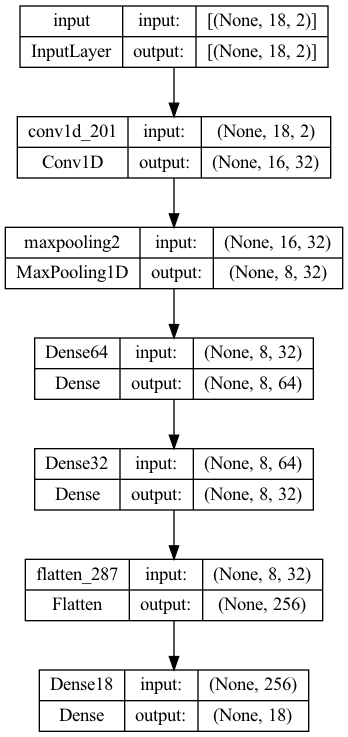

In [1082]:
integ = Integrator(XX_meta, YY_meta, bs_counts=18)
integ.UnderSampling().train_test_split()
integ.compile(loss='binary_crossentropy', metrics = None)
integ.build_model()
integ.model_summary()

Epoch 1/50


2024-08-14 15:50:44.439720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 4.7863 - binary_accuracy: 0.4722 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6707 - f1_score: 0.0546

2024-08-14 15:50:46.452584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 2s/step - loss: 4.7863 - binary_accuracy: 0.4722 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6707 - f1_score: 0.0546 - val_loss: 3.2745 - val_binary_accuracy: 0.5510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7255 - val_f1_score: 0.0611
Epoch 2/50
2/2 [==============================] - 0s 102ms/step - loss: 3.8228 - binary_accuracy: 0.4722 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7121 - f1_score: 0.0560 - val_loss: 2.9647 - val_binary_accuracy: 0.5510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7134 - val_f1_score: 0.0640
Epoch 3/50
2/2 [==============================] - 0s 89ms/step - loss: 3.4912 - binary_accuracy: 0.4722 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7142 - f1_score: 0.0595 - val_loss: 2.8120 - val_binary_accuracy: 0.5510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7319 - val_f1_score: 0.0690
Epoch 4/50
2/2 [=====================

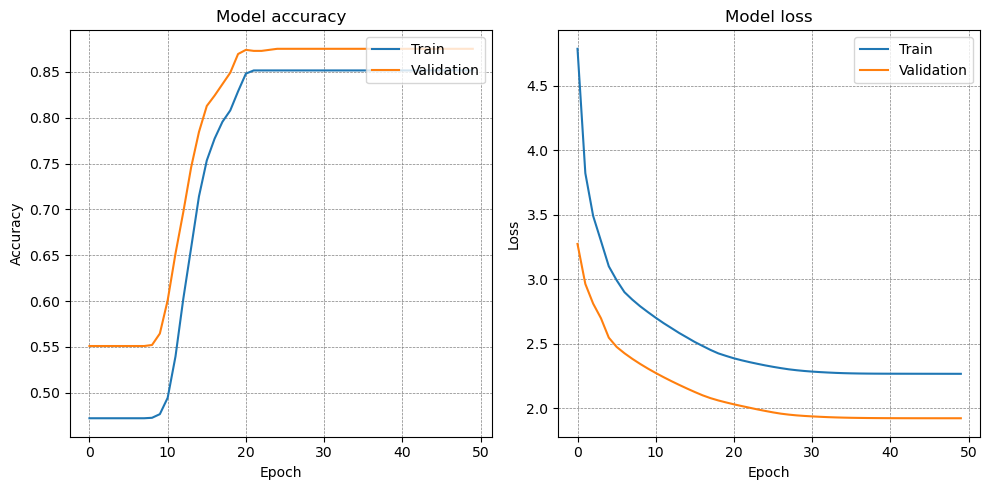

1/1 [==============================] - 0s 158ms/step


2024-08-14 15:50:50.939353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


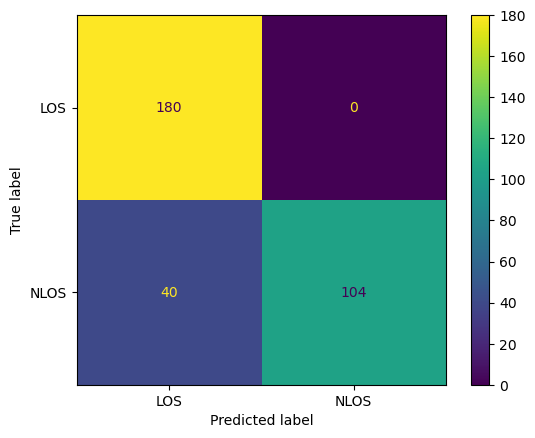

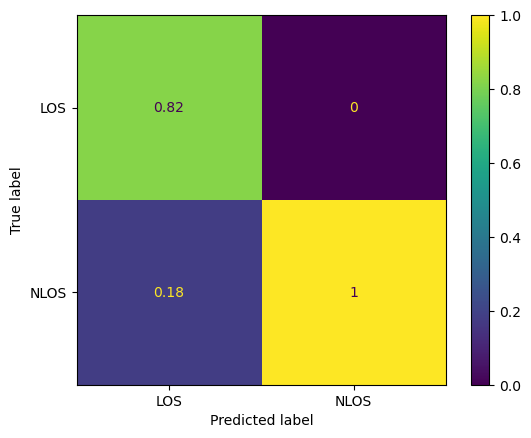

In [1083]:
integ.fit(epochs=50, batch_size=64, verbose=1, validation_split = 0.3)
integ.plot_history()

integ.predict()
y_pred_f = integ.confusion_matrix()

In [495]:
test = np.array(XX_meta).reshape((-1,2))
test.shape

(102240, 2)

Relevant Literature: 

[1] <a href="https://arxiv.org/pdf/2405.09839">Heterogenious Federated Learning</a>

[2] <a href="https://link.springer.com/article/10.1007/s40747-023-01110-7">A federated learning algorithm using parallel-ensemble ... - Springer</a>

[3] <a href="https://dl.acm.org/doi/fullHtml/10.1145/3673038.3673074">ChronusFed: Reinforcement-Based Adaptive Partial Training for</a>

[4] <a href="https://ieeexplore.ieee.org/document/10093881">Simple Effecient Lighweight (SEL-CNN): A chain of CNNs --> Accuracy: 93.31%</a>

[5] <a href="https://ieeexplore.ieee.org/abstract/document/9264122">Cahallenges of DL: computational and storage overhead,</a> this is an overview paper, indicating that EL is not applied for IPSs. However, a few implementation of bosting methods are reported.

[6] <a href="https://ieeexplore.ieee.org/abstract/document/10005609">Four typical lightweight ML algorithms,</a> namely, classification tree (CT), k -nearest neighbor (KNN), classification ensembles (CEs) and support vector machines (SVMs) for ToA tracking through 5G DMRS

[7] <a href="https://www.mdpi.com/1424-8220/23/3/1470">homogenious EL (XGBoost and RF) for 5G PRS-DL in MIMO setting and CIR retrived from TDL/CDL channels</a>  -->  up to 28% better performance than threshold-based approaches.

    * Model-driven category, where a statistical model followed by thresholding can be used to separate between LOS and NLOS scenarios, e.g., [7,8,9,10,11].

    * Data-driven category, where some form of training data for LOS and NLOS cases is available to train some models via feature extraction, followed by some ML classifier stage, e.g., [9,12,13,14,15,16,17,18,19].

[8] <a href="https://ieeexplore.ieee.org/abstract/document/8968748">ANN (MLP) with power angular spectrum (PAS) has the best performance for V2V comm. RF is also investigated.</a>

[9] <a href="https://www.sciencedirect.com/science/article/pii/S1874490723001210">K-means for labeling CSI to LOS/NLOS label using NYUSIM, then traing a pseudo-learned NN (PLNN) for</a> classification --> accuracy 87% better than 

[10] <a href="https://ieeexplore.ieee.org/abstract/document/9527899">A binary hypothesis testing between LOS and NLOS- An example of non data-driven approaches</a>

[11] <a href="https://dl.acm.org/doi/fullHtml/10.1145/3673038.3673074">Heterogeneous federated learning and Reinforcement learning in FL</a>

<center>
<figure>
    <img src="https://raw.githubusercontent.com/hamedtea/FederatedLearning/Undersampled_ver/FL_EL.webp?token=GHSAT0AAAAAACWDQFKANKYSQ63BZ3ZB7T4KZV4ZNOQ" width="680" height="440">
        <alt="FE_EL">
    <figcaption>Algorithm structure. Basic federated learning trains basic models, the predictions of which are used as the input of the meta-model. Meta-federated learning trains meta-model to obtain the output [3]</figcaption>
</figure>
</center>